In [ ]:
# Copyright 2023 NXP
# All rights reserved. 

# 1. Install depenencies  
Refer to [Maximum Path Length Limitation](https://learn.microsoft.com/en-us/windows/win32/fileio/maximum-file-path-limitation?tabs=powershell#enable-long-paths-in-windows-10-version-1607-and-later) if an OS error occurs on Windows.

In [ ]:
# Install all the necessary packages
%pip install -r requirements.txt

In [ ]:
# Import common packages
import numpy as np
import pandas as pd
import os
from os import path
import seaborn as sns
import matplotlib.pyplot as plt
from collections import namedtuple

#Set matplotlib settings
%matplotlib inline

# 2. Define helper functions  
These cells contain helper functions to communicate with the board, import and collect data, run animations, and create graphs.

### Serial interface to connect to the board

In [ ]:
import serial

class DevBoard():
    def __init__(self, com_port):
        self.__device = None
        self.__port = com_port
        self.__serial_buffer = ''
        self.__samples = []

    def connect(self):
        # Open the com port
        try:
            self.__device = serial.Serial(port=self.__port,
                                        baudrate=115200,
                                        bytesize=8,
                                        timeout=None,
                                        stopbits=serial.STOPBITS_ONE)
        except:
            print('Cannot open com port! Power cycle the board and try again.')

    def disconnect(self):
        if self.__device:
            self.__device.close()
            self.__device = None
            self.__serial_buffer = ''
            self.__samples = []

    def config(self, samples):
        # To sync with board
        self.__device.flush()
        self.__device.write('\n'.encode('Ascii'))

        self.__device.read_until('Number of Samples (0 for continuous): '.encode('Ascii'))
        self.__device.write(f'{samples}\n'.encode('Ascii'))
        self.__device.read_until(f'{samples}\n'.encode('Ascii'))

    def start(self):
        self.__device.write('\n'.encode('Ascii'))
        
    def __get_new_data(self):
        # Read all
        self.__serial_buffer += self.__device.read(self.__device.inWaiting()).decode('Ascii')
        split_buff = self.__serial_buffer.split('\n')
        self.__serial_buffer = split_buff.pop(-1)
        self.__samples.extend([[np.float32(n) for n in s.split(',') if n] for s in split_buff])
        pass

    def read_samples(self, n):
        self.__get_new_data()

        if len(self.__samples) < n:
            return None
        
        read_samples = self.__samples[:n]
        self.__samples = self.__samples[n:]
        return read_samples

    def read_all_samples(self):
        self.__get_new_data()

        if len(self.__samples) == 0:
            return None
            
        read_samples = self.__samples
        self.__samples = []
        return read_samples

### Functions to collect, save, and load data

In [ ]:
from datetime import datetime
from tqdm import tqdm
import csv

def collect_data(device:DevBoard,
                 filepath:str,
                 filename:str,
                 label:int,
                 frames:int):
    device.connect()
    device.config(frames)

    filepath = path.normpath(filepath)
    full_path = path.join(os.getcwd(), filepath)
    full_name = f'{filename}_{datetime.now().strftime("%m%d%Y%H%M%S")}.csv'

    if not os.path.exists(full_path):
        os.makedirs(full_path)

    with open(path.join(full_path, full_name), 'w', newline='') as file:
        writer = csv.writer(file)
        # write the header
        header = ['thermistor']
        header.extend([f'pixel{n}' for n in range(64)])
        header.append('label')
        writer.writerow(header)
        device.start()
        for i in tqdm(range(frames)):
            new_sample = None
            while not new_sample:
                new_sample = device.read_samples(1)
            new_sample = new_sample[0]
            new_sample.append(label)
            writer.writerow(new_sample)

    device.disconnect()

def load_dataset(data_paths:list):
    data = list()
    for data_path in data_paths:
        # Get the path
        data_path = path.normpath(data_path)
        data_path = os.path.join(os.getcwd(), data_path)

        # Iterate through all files in csv and import data
        for root,_,files in os.walk(data_path):
            for file in files:
                if file.endswith('.csv'):
                    # Read the file
                    file_data = pd.read_csv(path.join(root, file))
                    data.append(file_data)

    if len(data) == 0:
        return None
    
    return pd.concat(data)

### Functions to plot and animate data

In [ ]:
from IPython.display import display, clear_output
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(actual, predicted, labels, title=''):
    #Create confusion matrix and normalizes it over predicted (columns)
    cm = confusion_matrix(actual, predicted)
    cm_n = confusion_matrix(actual, predicted, normalize='pred')
    fig, ax = plt.subplots(figsize=(6,5))
    ax.set_title(title)
    sns.heatmap(cm.astype(int),
                annot=True, 
                fmt='d', 
                annot_kws={'va':'top'},
                xticklabels=labels, 
                yticklabels=labels,
                cbar=False)
    sns.heatmap(cm_n, 
                annot=True, 
                fmt='.1%', 
                annot_kws={'va':'bottom'},
                xticklabels=labels, 
                yticklabels=labels,
                cbar=False)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show(block=False)
    
# Show a single frame
def show_frame(frame, label=None, ax=None, cbar=False, figisze=(4,3)):
    if not ax:
        _,ax = plt.subplots(figsize=figisze)

    sns.heatmap(frame, cbar=cbar, ax=ax)

    if label:
        ax.set_title(label)
        
    ax.invert_yaxis()
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)

def run_animation(device:DevBoard,
                  frame_dims, 
                  model=None, labels=None, 
                  threshold=0.9):
    def extract_label(outputs):
        label = np.argmax(outputs, axis=1).item()
        return (label, outputs[0][label])

    def animate(ax, frame):
        show_frame(frame.reshape(frame_dims[:-1]), 
                    cbar=False, ax=ax)

    def run_inference(ax, frame):
        input = np.reshape(frame, (1,)+frame.shape)
        output = model.predict(input, verbose=False)[0]
        title = ''
        for i,certainty in enumerate(output):
            if labels and i in range(len(labels)):
                if certainty >= threshold:
                    title += '*' 
                title += f'{labels[i]}-'
            title += f'{i} : {certainty:0.2f}\n'
        ax.set_title(title)
            
    device.connect()
    device.config(0)
    device.start()
    
    try:
        fig,ax = plt.subplots()
        while True:
            new_frame = device.read_samples(1)
            if new_frame:
                new_frame = new_frame[0]
                thermistor = new_frame[0]
                new_frame = np.reshape(new_frame[1:], frame_dims)
                # new_frame /= thermistor
                animate(ax, new_frame)
                if model:
                    run_inference(ax, new_frame)

                display(fig)
                clear_output(wait=True)
    except:
        clear_output(wait=True)
        device.disconnect()

### Function to save model

In [ ]:
import tensorflow as tf
import tensorflow.lite as tflite
from tensorflow.lite.python.util import convert_bytes_to_c_source
    
def convert_to_c(tflite_model, file_name, save_path):
    source_text, header_text = convert_bytes_to_c_source(tflite_model,  file_name)
    file_path = path.normpath(path.join(os.getcwd(), save_path))
    
    if not os.path.exists(file_path):
        os.makedirs(file_path)

    file_path = path.join(file_path, file_name)

    with  open(f'{file_path}.h',  'w')  as  file:
        file.write(header_text)

    with  open(f'{file_path}.cpp',  'w')  as  file:
        file.write(f'\n#include \"{file_name}.h\"\n')
        file.write(source_text)

# Models are saved in ./models/
def save_model(model, name, representative_data_gen):
    root_path = path.normpath(path.join(os.getcwd(), 'models'))
    
    if not os.path.exists(root_path):
        os.makedirs(root_path)

    keras_path = path.join(root_path, f'{name}.keras')
    tflite_path = path.join(root_path, f'{name}.tflite')
    tflite_quant_path = path.join(root_path, f'{name}_quant.tflite')

    # store the keras model
    print("Save keras model")
    model.save(keras_path)
    
    # convert keras model into tf lite model
    print("Convert and save tflite model")
    converter = tflite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    # convert keras model into quantized tf lite model
    print("Convert and save tflite model - quantized")    
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_data_gen
    tflite_model_quant = converter.convert()
    
    # store the tf lite models
    open(tflite_path, "wb").write(tflite_model)
    open(tflite_quant_path, "wb").write(tflite_model_quant)
    
    # convert to C source code and store it
    convert_to_c(tflite_model, f'{name}_tflite', 'models/src')
    convert_to_c(tflite_model_quant, f'{name}_tflite_quant', 'models/src')

    print("Done!")

    return tflite_model, tflite_model_quant

def run_tflite_inference(model, data):
    interpreter = tf.lite.Interpreter(model_content=model)
    interpreter.resize_tensor_input(0, data.shape)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    interpreter.set_tensor(input_details[0]['index'], data)

    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])
    return output_data

# 3. Define constants and parameters  
Make sure that `COM_PORT` corresponds to the board serial port. If this is not set correctly, you won't be able to collect data nor run the animation in step 13.

In [ ]:
TempRange = namedtuple('TempRange', ['min','max'])
FrameDims = namedtuple('FrameDims', ['height', 'width', 'channels'])

In [ ]:
# Change this to fit your use case
SAMPLING_RATE_HZ = 10
FRAME_DIMS = FrameDims(8,8,1)
COM_PORT = 'COM38'
LABELS = ['no-presence', 'one', 'two']
BOARD = DevBoard(COM_PORT)
TEMP_RANGE = TempRange(0.0, 80.0)

# 4. Collect sensor data (optional)  
This is an optional step in case you want to collect your own data for a different type of model.  
Open the MCU project in MCUXpresso and make sure that ```APP_COLLECT_DATA``` is defined in main.cpp. Build the project and flash it to the board.

In [ ]:
CLASS_NAME = 'one'

collect_data(device=BOARD,
             filepath=f'data/train/{CLASS_NAME}',
             filename=CLASS_NAME, 
             label=LABELS.index(CLASS_NAME),
             frames=50)

# 5. Load the dataset

### Load custom dataset  
You can use this to load the data you collected in step 4.

In [ ]:
dataset_df = load_dataset(data_paths=['data/train'])

### or

### Load LINAIGE dataset  
This dataset is a collecdtion of frames from ceiling-mounted sensors in different rooms. Please refer to the research papers for more information.

Source:  
* [LINAIGE Dataset](https://www.kaggle.com/datasets/francescodaghero/linaige)

Authors:  
* Xie, Chen  
* Daghero, Francesco  
* Chen, Yukai  
* Castellano, Marco  
* Gandolfi, Luca  
* Calimera, Andrea  
* Macii, Enrico  
* Poncino, Massimo  
* Jahier Pagliari, Daniele  

Related Papers:  
* [Privacy-preserving Social Distance Monitoring on Microcontrollers with Low-Resolution Infrared Sensors and CNNs](https://arxiv.org/pdf/2204.10541.pdf)
* [Efficient Deep Learning Models for Privacy-preserving People Counting on Low-resolution Infrared Arrays](https://arxiv.org/pdf/2304.06059.pdf)  
  
License:  
* [Attribution 4.0 International (CC BY 4.0)](https://creativecommons.org/licenses/by/4.0/)


In [ ]:
dataset_df = load_dataset(['data/linaige/'])
# Keeping only the easy frames and at most two people
dataset_df = dataset_df[dataset_df["confidence"]=="e"]
dataset_df = dataset_df[dataset_df["people_number"]<=2]
# Add label column
dataset_df["label"] = (dataset_df["people_number"]).astype(int)

# 6. Balance the dataset  
Ensure that classes are evenly represented in the dataset. This method downsamples classes that are over represented.

In [ ]:
counts = []
subsets = []
for i in range(len(LABELS)):
    subsets.append(dataset_df.loc[dataset_df["label"] == i, :])
    counts.append(len(subsets[i]))

min_len = min(counts)
sampled_classes = []
for i in range(len(LABELS)):
    subset = dataset_df.loc[dataset_df["label"] == i, :]
    sampled_classes.append(subset.sample(min_len))

balanced_df = pd.concat(sampled_classes, ignore_index=True)

# 7. Split the dataset into train, validation, and test

In [ ]:
from sklearn.model_selection import train_test_split

# Get the mean and variance of the data
dataset_mean = balanced_df.loc[:,'pixel0':'pixel63'].to_numpy().mean()
dataset_var = balanced_df.loc[:,'pixel0':'pixel63'].to_numpy().var()

train_df, test_df = train_test_split(balanced_df, test_size=0.1, shuffle=True)
train_df, validation_df = train_test_split(train_df, test_size=0.2, shuffle=True)

X_train = train_df.loc[:,'pixel0':'pixel63'].to_numpy().reshape((-1,)+FRAME_DIMS).astype(np.float32)
y_train = train_df["label"].to_numpy().astype(int)

X_validation = validation_df.loc[:,'pixel0':'pixel63'].to_numpy().reshape((-1,)+FRAME_DIMS).astype(np.float32)
y_validation = validation_df["label"].to_numpy().astype(int)

X_test = test_df.loc[:,'pixel0':'pixel63'].to_numpy().reshape((-1,)+FRAME_DIMS).astype(np.float32)
y_test = test_df["label"].to_numpy().astype(int)

# 8. Analyze the data  
Analyze the data split and class breakdown for each set.

In [ ]:
total_samples = len(X_train) + len(X_validation) + len(X_test)
class_count_dataset = np.zeros(len(LABELS))
class_count_train = np.zeros(len(LABELS))
class_count_validation = np.zeros(len(LABELS))
class_count_test = np.zeros(len(LABELS))
for i in range(len(LABELS)):
    class_count_train[i] = np.count_nonzero(y_train == i)
    class_count_validation[i] = np.count_nonzero(y_validation == i)
    class_count_test[i] = np.count_nonzero(y_test == i)
    class_count_dataset[i] = class_count_test[i] + \
                             class_count_validation[i] + \
                             class_count_test[i]

print(f'Dataset size: {total_samples}')
print(f'Train size: {len(X_train)} | {(len(X_train)/total_samples)*100:0.2f}%')
print(f'Validation size: {len(X_validation)} | {(len(X_validation)/total_samples)*100:0.2f}%')
print(f'Test size: {len(X_test)} | {(len(X_test)/total_samples)*100:0.2f}%')

print(f'Dataset class breakdown: {np.round(class_count_dataset/np.sum(class_count_dataset), 2)}')
print(f'Train class breakdown: {np.round(class_count_train/np.sum(class_count_train), 2)}')
print(f'Validation class breakdown: {np.round(class_count_validation/np.sum(class_count_validation), 2)}')
print(f'Test class breakdown: {np.round(class_count_test/np.sum(class_count_test), 2)}')

Visualize a couple of samples to get a better idea of how the data looks.

In [ ]:
import random

SAMPLES_TO_SHOW = 3
rand_sample_idxs = random.sample(range(len(X_train)), SAMPLES_TO_SHOW)
for i,idx in enumerate(rand_sample_idxs):
    sample = X_train[idx].reshape(FRAME_DIMS[:-1])
    label = LABELS[y_train[idx]]
    show_frame(frame=sample, label=label, cbar=True)

# 9. Define the model

### Create a new model

In [ ]:
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Input, Conv2D, Dropout, \
                         BatchNormalization, Flatten, \
                         MaxPooling2D, RandomFlip, Normalization


preprocess = [
    Input(shape=FRAME_DIMS, name='image'),
    RandomFlip(),
    Normalization(mean=dataset_mean, variance=dataset_var)
]

hidden = []
for l in [32,64]:
    hidden.append(BatchNormalization())
    hidden.append(Conv2D(l, (3, 3), activation='relu', padding='same'),)
    hidden.append(MaxPooling2D((2, 2)))
    hidden.append(Dropout(0.2))

classifier = [
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(LABELS), activation='softmax', name='prediction')        
]

model = Sequential(preprocess + hidden + classifier)
optimizer = keras.optimizers.Adam(0.001)
model.compile(
    optimizer,
    'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

### or

### Load an existing model

In [ ]:
model = tf.keras.models.load_model("models/model.keras")
model.summary()

# 10. Train

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_validation, y_validation),
    verbose=True,
)

# 11. Analyze train results

### Plot training accuracy and loss

In [ ]:
df_history = pd.DataFrame(history.history)
fig, ax = plt.subplots(2)
plot_loss = sns.lineplot(data=df_history[['loss', 'val_loss']], ax=ax[0])
plt.setp(ax[0].get_xticklabels(), visible=False)
plot_acc = sns.lineplot(data=df_history[['accuracy', 'val_accuracy']], ax=ax[1])
plot_acc.set_xlabel('Epochs')

### Plot training data confusion matrix

In [ ]:
preds = model.predict(X_train, verbose=False)
preds = np.argmax(preds, axis=1)
plot_confusion_matrix(y_train, preds, LABELS, 'Train Data')

### Plot validation data confusion matrix

In [ ]:
preds = model.predict(X_validation, verbose=False)
preds = np.argmax(preds, axis=1)
plot_confusion_matrix(y_validation, preds, LABELS, 'Validation Data')

# 12. Test model with test data

In [ ]:
preds = model.predict(X_test, verbose=False)
preds = np.argmax(preds, axis=1)
plot_confusion_matrix(y_test, preds, LABELS, 'Test Data')

# 13. Run model with realtime data  
This gathers real-time data from the board, runs in through the model, and outputs a real-time animation of the results.  
Open the MCU project in MCUXpresso and make sure that ```APP_COLLECT_DATA``` is defined in main.cpp. Build the project and flash it to the board.  
The animation should look like this:  
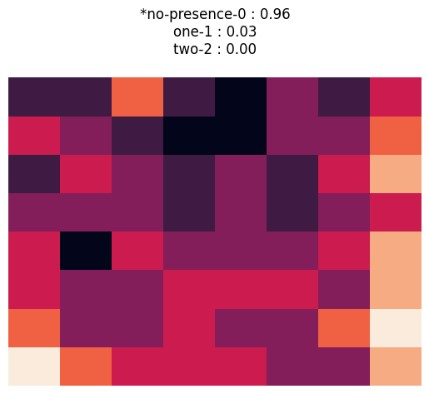

In [ ]:
run_animation(device=BOARD,
              frame_dims=FRAME_DIMS,
              model=model, 
              labels=LABELS,
              threshold=0.8)

# 14. Save and convert the model to run on device  
Once saved, open  the MCU project in MCUXpresso, comment out ```APP_COLLECT_DATA``` in main.cpp, re-build the project, and flash it to the board.

In [ ]:
def representative_dataset():
  for data in tf.data.Dataset.from_tensor_slices((X_train)).batch(1).take(100):
    yield {
      "image": data
    }

tfl_model, tfl_quant_model = save_model(model, 'model', representative_dataset)

# 15. Test Converted Models

### TFLite

In [ ]:
preds = run_tflite_inference(tfl_model, X_train)
preds = np.argmax(preds, axis=1)
plot_confusion_matrix(y_train, preds, LABELS, 'Train Data')

preds = run_tflite_inference(tfl_model, X_validation)
preds = np.argmax(preds, axis=1)
plot_confusion_matrix(y_validation, preds, LABELS, 'Validation Data')

preds = run_tflite_inference(tfl_model, X_test)
preds = np.argmax(preds, axis=1)
plot_confusion_matrix(y_test, preds, LABELS, 'Test Data')

### TFLite Quantized

In [ ]:
preds = run_tflite_inference(tfl_quant_model, X_train)
preds = np.argmax(preds, axis=1)
plot_confusion_matrix(y_train, preds, LABELS, 'Train Data')

preds = run_tflite_inference(tfl_quant_model, X_validation)
preds = np.argmax(preds, axis=1)
plot_confusion_matrix(y_validation, preds, LABELS, 'Validation Data')

preds = run_tflite_inference(tfl_quant_model, X_test)
preds = np.argmax(preds, axis=1)
plot_confusion_matrix(y_test, preds, LABELS, 'Test Data')